# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Компания планирует расширение производственных мощностей и рассматривает возможность бурения новой скважины. Для принятия решения о наиболее перспективной локации необходимо определить регион, в котором добыча нефти принесёт максимальную прибыль.

Нам компания предоставила данные о пробах нефти в трёх регионах, каждый из которых включает 10 000 месторождений с измеренными характеристиками — качеством нефти и объёмом её запасов. Основная наша задача заключается в построении модели машинного обучения, которая позволит оценить перспективность каждого региона и выбрать тот, где добыча будет наиболее выгодной.

Прежде, чем выборать регион, нам необходимо сделать нескольких этапов:

 - Сбор и анализ данных: для каждого месторождения в выбранном регионе оцениваются ключевые признаки.
 - Построение модели: на основе собранных данных создаётся модель, которая прогнозирует объём запасов нефти.
 - Выбор месторождений: определяются месторождения с наивысшими оценками запасов. Количество выбираемых месторождений зависит от бюджета компании и стоимости разработки одной скважины.
 - Расчёт прибыли: рассчитывается суммарная прибыль от отобранных месторождений, которая позволит оценить экономическую целесообразность разработки региона.

Для оценки возможной прибыли и рисков будет использован метод Bootstrap. Этот подход позволит более точно прогнозировать прибыль с учётом возможных колебаний объёмов добычи и других факторов, влияющих на рентабельность проекта.

## Загрузка и подготовка данных

In [99]:
!pip install numba==0.59.1 -q
!pip install numpy==1.26.4 -q
!pip install scipy==1.13.1 -q
!pip install -U scikit-learn -q
!pip install seaborn==0.13.2 -q
!pip install matplotlib==3.9.0 -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.25

Для начала загрузим наши исходные датасеты.

In [100]:
data_0 = pd.read_csv('geo_data_0.csv') # первый регион
data_1 = pd.read_csv('geo_data_1.csv') # второй регион
data_2 = pd.read_csv('geo_data_2.csv') # третий регион

In [101]:
display(data_0.head(5))
data_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [102]:
display(data_1.head(5))
data_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [103]:
display(data_2.head(5))
data_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Выведем количество пропусков в каждом датасете

In [104]:
print(data_0.isna().sum())
print(data_1.isna().sum())
print(data_2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Как мы видим, в наших исходных датасетах отсутствуют пропуски и также, во всех столбцах используется корректный тип данных.

Далее займемся предобработкой исходных данных. Произведем проверку наших датасетов сначала на наличие полных дубликатов а потом на наличие неявных

In [105]:
print(data_0.duplicated().sum())
print(data_1.duplicated().sum())
print(data_2.duplicated().sum())

0
0
0


In [106]:
print(data_0['id'].value_counts().head(12))
display(data_0[data_0.duplicated(['id'],keep=False)])
print()
print(data_1['id'].value_counts().head(6))
display(data_1[data_1.duplicated(['id'],keep=False)])
print()
print(data_2['id'].value_counts().head(6))
display(data_2[data_2.duplicated(['id'],keep=False)])

id
fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
A5aEY    2
bsk9y    2
TtcGQ    2
HZww2    2
bxg6G    2
iAaqy    1
PQ2MT    1
Name: count, dtype: int64


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205



id
wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
lAVJZ    1
Name: count, dtype: int64


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044



id
VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
fwXo0    1
B9hou    1
Name: count, dtype: int64


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


В таком виде неудобно сравнивать значения id, поэтому сгруппируем их по уникальному значению

In [107]:
print('Повторные значения id для таблицы data_0')
id_0 = data_0.loc[data_0['id'].duplicated(), 'id'].values
for i in id_0:
    display(data_0.loc[data_0['id'] == i])
print()

print('Повторные значения id для таблицы data_1')   
id_1 = data_1.loc[data_1['id'].duplicated(), 'id'].values
for i in id_1:
    display(data_1.loc[data_1['id'] == i])
print()

print('Повторные значения id для таблицы data_2')   
id_2 = data_2.loc[data_2['id'].duplicated(), 'id'].values
for i in id_2:
    display(data_2.loc[data_2['id'] == i])

Повторные значения id для таблицы data_0


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302



Повторные значения id для таблицы data_1


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


,id,f0,f1,f2,product
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044



Повторные значения id для таблицы data_2


,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


,id,f0,f1,f2,product
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Хоть мы и видим, что некоторые id повторяются в наших датасетах, но все значения у скажин с этими id разные. Поэтому оставим эти данные без изменений и обработки.

Далее чтобы проанализировать наши исходные данные на выбросы визуализируем их

In [108]:
display(data_0.describe())
display(data_1.describe())
display(data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Построим гистограммы и произведем анализ выбросов данных числовых данных для первого региона data_0

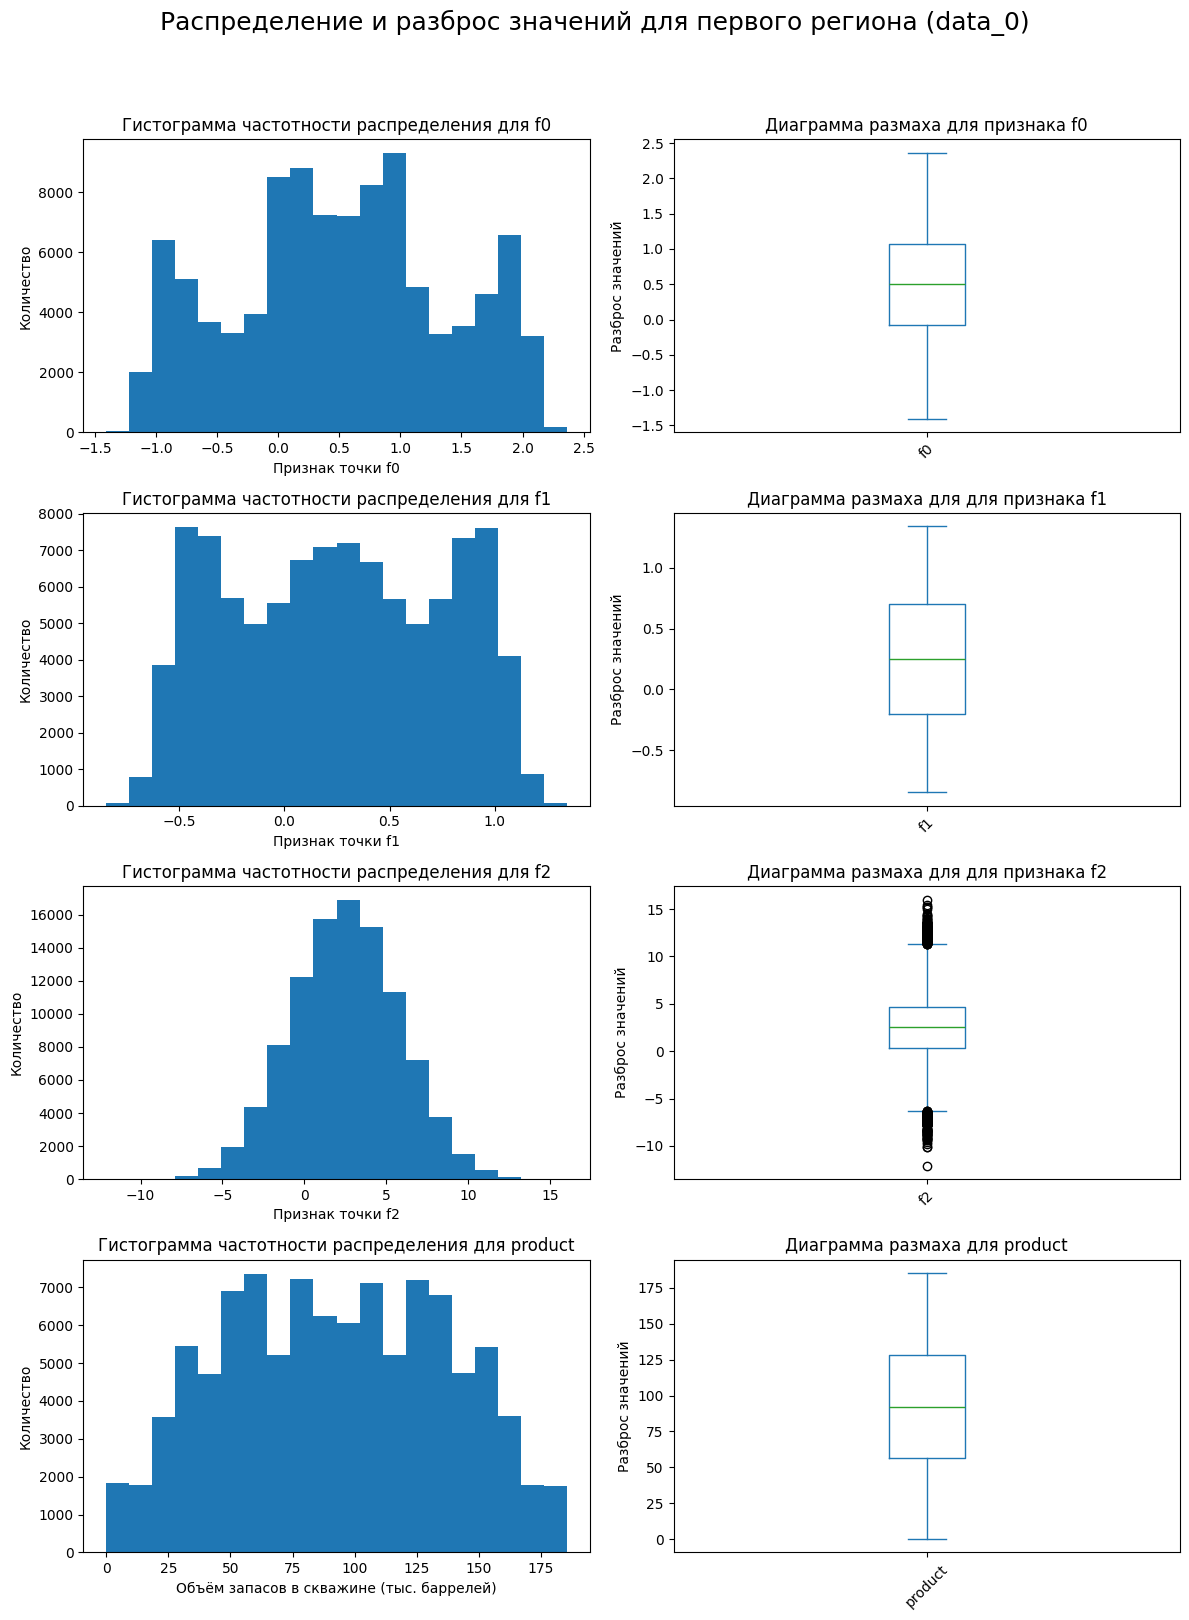

In [109]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,17))
fig.suptitle('Распределение и разброс значений для первого региона (data_0)', fontsize=18)

# Графики для f0
data_0['f0'].plot(kind='hist', bins=20, ax=axes[0, 0])
axes[0, 0].set_title('Гистограмма частотности распределения для f0')
axes[0, 0].set_xlabel('Признак точки f0')
axes[0, 0].set_ylabel('Количество')

data_0['f0'].plot(kind='box', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Диаграмма размаха для признака f0')
axes[0, 1].set_ylabel('Разброс значений')

# Графики для f1
data_0['f1'].plot(kind='hist', bins=20, ax=axes[1, 0])
axes[1, 0].set_title('Гистограмма частотности распределения для f1')
axes[1, 0].set_xlabel('Признак точки f1')
axes[1, 0].set_ylabel('Количество')

data_0['f1'].plot(kind='box', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Диаграмма размаха для для признака f1')
axes[1, 1].set_ylabel('Разброс значений')

# Графики для f2
data_0['f2'].plot(kind='hist', bins=20, ax=axes[2, 0])
axes[2, 0].set_title('Гистограмма частотности распределения для f2')
axes[2, 0].set_xlabel('Признак точки f2')
axes[2, 0].set_ylabel('Количество')

data_0['f2'].plot(kind='box', ax=axes[2, 1], rot=45)
axes[2, 1].set_title('Диаграмма размаха для для признака f2')
axes[2, 1].set_ylabel('Разброс значений')

# Графики для product
data_0['product'].plot(kind='hist', bins=20, ax=axes[3, 0])
axes[3, 0].set_title('Гистограмма частотности распределения для product')
axes[3, 0].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
axes[3, 0].set_ylabel('Количество')

data_0['product'].plot(kind='box', ax=axes[3, 1], rot=45)
axes[3, 1].set_title('Диаграмма размаха для product')
axes[3, 1].set_ylabel('Разброс значений')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Как мы видим из описания данных, значения для признака f0 варьируются от -1.4 до 2.3, для признака f1 значения варьируются от -0.8 до 1.3, а для признака f2 от -12 до 16. Объем запасов же составляет от 0 до 185 тыс. баррелей. Также по диаграмме размаха можно заметить множество выбрасов у признака f2, поэтому эти данные лучше удалить, потому что они могут негативно повлиять на обучение модели, создавая лишний шум, и их количество составляет малую часть от исходных данных.
И также далее проверим корреляцию между признаками

In [110]:
correlation_matrix_0 = data_0.drop(columns=['id']).corr()
display(correlation_matrix_0)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Признаки f1 и f0 имеют слабую корреляцию. Признак f2 имеет умеренную положительную корреляцию с целевым признаком product равную 0.483663. Взаимные корреляции между другими признаками (f0, f1, f2) очень малы, что говорит о очень слабой зависимости между ними, или же вообще об ее отсутсвии.

In [111]:
data_0 = data_0.loc[(data_0['f2'] >= -7) & (data_0['f2'] <= 12)]

Далее сделаем то же самое для двух других регионов data_1 и data_2

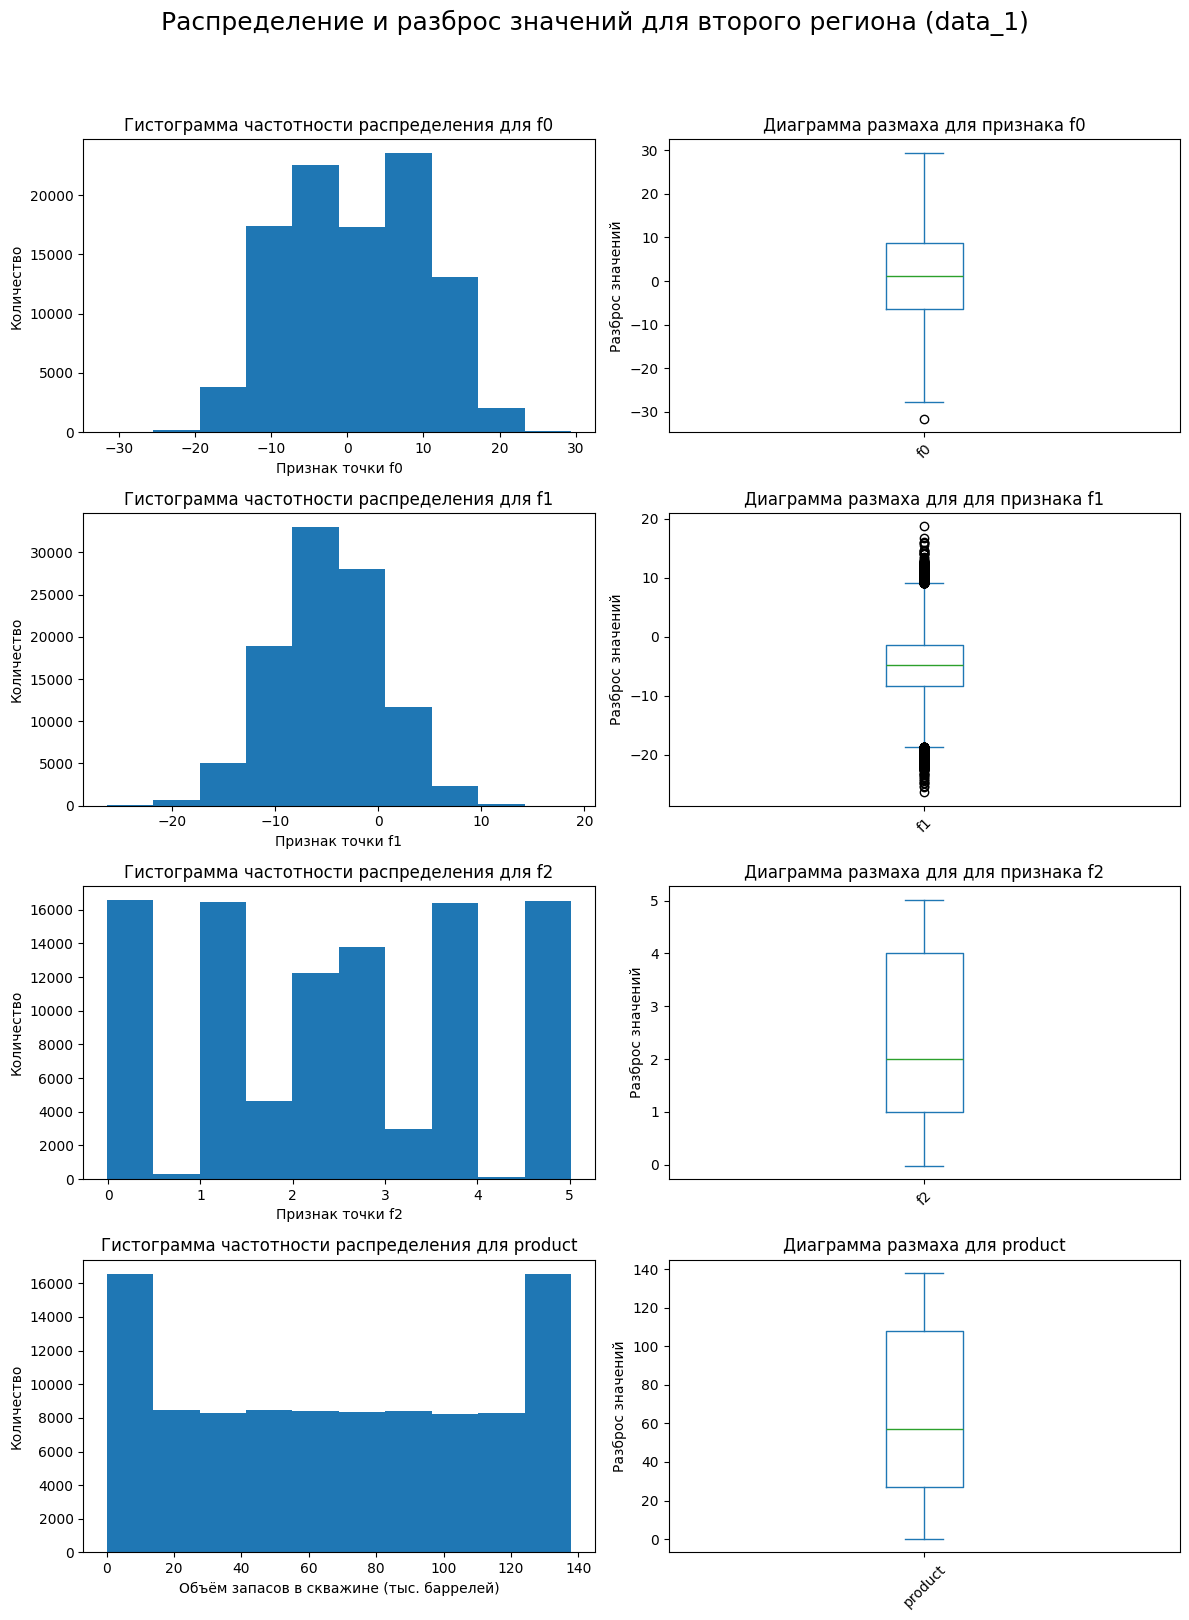

In [112]:
# data_1
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,17))
fig.suptitle('Распределение и разброс значений для второго региона (data_1)', fontsize=18)

# Графики для f0
data_1['f0'].plot(kind='hist', bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Гистограмма частотности распределения для f0')
axes[0, 0].set_xlabel('Признак точки f0')
axes[0, 0].set_ylabel('Количество')

data_1['f0'].plot(kind='box', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Диаграмма размаха для признака f0')
axes[0, 1].set_ylabel('Разброс значений')

# Графики для f1
data_1['f1'].plot(kind='hist', bins=10, ax=axes[1, 0])
axes[1, 0].set_title('Гистограмма частотности распределения для f1')
axes[1, 0].set_xlabel('Признак точки f1')
axes[1, 0].set_ylabel('Количество')

data_1['f1'].plot(kind='box', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Диаграмма размаха для для признака f1')
axes[1, 1].set_ylabel('Разброс значений')

# Графики для f2
data_1['f2'].plot(kind='hist', bins=10, ax=axes[2, 0])
axes[2, 0].set_title('Гистограмма частотности распределения для f2')
axes[2, 0].set_xlabel('Признак точки f2')
axes[2, 0].set_ylabel('Количество')

data_1['f2'].plot(kind='box', ax=axes[2, 1], rot=45)
axes[2, 1].set_title('Диаграмма размаха для для признака f2')
axes[2, 1].set_ylabel('Разброс значений')

# Графики для product
data_1['product'].plot(kind='hist', bins=10, ax=axes[3, 0])
axes[3, 0].set_title('Гистограмма частотности распределения для product')
axes[3, 0].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
axes[3, 0].set_ylabel('Количество')

data_1['product'].plot(kind='box', ax=axes[3, 1], rot=45)
axes[3, 1].set_title('Диаграмма размаха для product')
axes[3, 1].set_ylabel('Разброс значений')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Как мы видим из описания данных, значения для признака f0 варьируются примерно от -31 до 29, для признака f1 значения варьируются от -26 до 18, а для признака f2 примерно от 0 до 5. Объем запасов же составляет от 0 до 137 тыс. баррелей. На диаграмме размаха также заметны выбросы у признака f1, поэтому их стоит удалить. Эти данные могут внести лишний шум и негативно сказаться на обучении модели, тем более что их доля незначительна по сравнению с общим объемом данных. Также на гистограмме рапределения по объему нефти на скважину, тыс. барелей (product) мы можем заметить большое количество 0х значений.

In [113]:
data_1_null = data_1[data_1['product'] == 0]['product'].count()
percent = round((data_1_null / data_1.shape[0]) * 100, 3)
print('Количество нулевых значений в product:', data_1_null)
print('Процент нулевых значений от общего числа строк:', percent,'%')

Количество нулевых значений в product: 8235
Процент нулевых значений от общего числа строк: 8.235 %


Согласно графику и выведенным данным, колонка product, где описывается объем нефти на скважину, содержит 8235 нулевых значений (8.235% от общего числа строк). Причины нулевых значений могут быть таковы, что возможно эти скважины могли быть закрыты или находиться на стадии строительства/подготовки, поэтому объем добычи равен нулю, также возможна ошибка или отсутствие данных при сборе информации. Далее проверим корреляцию между признаками

In [114]:
correlation_matrix_1 = data_1.drop(columns=['id']).corr()
display(correlation_matrix_1)

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Признаки f0 и f1 не оказывают значимого влияния на product, так как их корреляции близки к нулю. Как мы можем заметить корреляция между f2 и product равна 0.999 — это практически полная положительная корреляция. Это говорит о том, что признаки f2 и product связаны очень сильно и линейно. Когда значения f2 увеличиваются, значения product практически всегда увеличиваются, и наоборот. Признак f2 не стоит удалять, так как его высокая корреляция с целевым признаком помогает точнее предсказывать результат.

In [115]:
data_1 = data_1.loc[(data_1['f1'] >= -20) & (data_1['f1'] <= 10)]

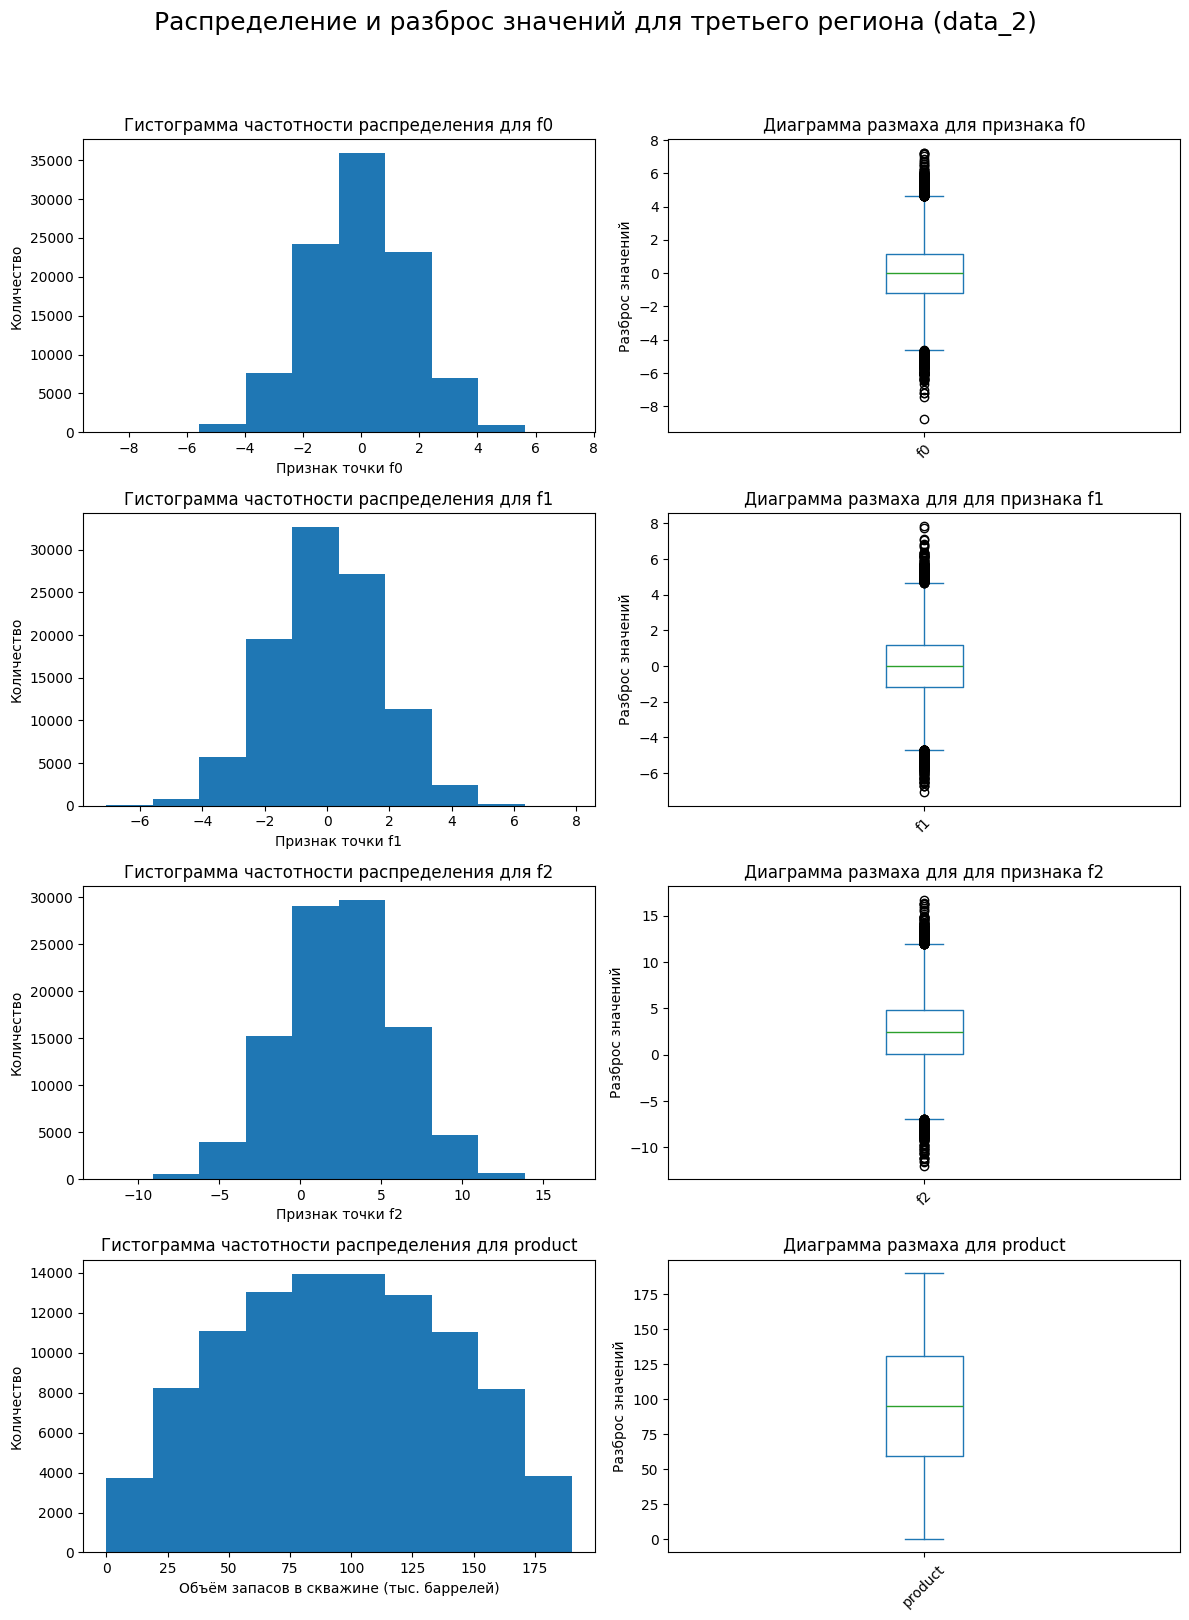

In [116]:
# data_2
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,17))
fig.suptitle('Распределение и разброс значений для третьего региона (data_2)', fontsize=18)

# Графики для f0
data_2['f0'].plot(kind='hist', bins=10, ax=axes[0, 0])
axes[0, 0].set_title('Гистограмма частотности распределения для f0')
axes[0, 0].set_xlabel('Признак точки f0')
axes[0, 0].set_ylabel('Количество')

data_2['f0'].plot(kind='box', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Диаграмма размаха для признака f0')
axes[0, 1].set_ylabel('Разброс значений')

# Графики для f1
data_2['f1'].plot(kind='hist', bins=10, ax=axes[1, 0])
axes[1, 0].set_title('Гистограмма частотности распределения для f1')
axes[1, 0].set_xlabel('Признак точки f1')
axes[1, 0].set_ylabel('Количество')

data_2['f1'].plot(kind='box', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Диаграмма размаха для для признака f1')
axes[1, 1].set_ylabel('Разброс значений')

# Графики для f2
data_2['f2'].plot(kind='hist', bins=10, ax=axes[2, 0])
axes[2, 0].set_title('Гистограмма частотности распределения для f2')
axes[2, 0].set_xlabel('Признак точки f2')
axes[2, 0].set_ylabel('Количество')

data_2['f2'].plot(kind='box', ax=axes[2, 1], rot=45)
axes[2, 1].set_title('Диаграмма размаха для для признака f2')
axes[2, 1].set_ylabel('Разброс значений')

# Графики для product
data_2['product'].plot(kind='hist', bins=10, ax=axes[3, 0])
axes[3, 0].set_title('Гистограмма частотности распределения для product')
axes[3, 0].set_xlabel('Объём запасов в скважине (тыс. баррелей)')
axes[3, 0].set_ylabel('Количество')

data_2['product'].plot(kind='box', ax=axes[3, 1], rot=45)
axes[3, 1].set_title('Диаграмма размаха для product')
axes[3, 1].set_ylabel('Разброс значений')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Из описания данных видно, что значения признака f0 колеблются примерно от -8.7 до 7.2, для f1 — от -7 до 7.8, а для f2 — от -11.9 до 16.7. Объем запасов варьируется от 0 до 190 тыс. баррелей. На диаграмме размаха также выявлены выбросы для признаков f0, f1 и f2, что предполагает необходимость их удаления. Эти выбросы могут создавать лишний шум и негативно влиять на обучение модели, тем более что их доля мала по сравнению с общим объемом данных. И также далее проверим корреляцию между признаками

In [117]:
correlation_matrix_2 = data_2.drop(columns=['id']).corr()
display(correlation_matrix_2)

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Признаки f0 и f1 не оказывают значимого влияния на product, так как их корреляции близки к нулю. Признак f2 имеет умеренную положительную корреляцию с product, что подчеркивает важность f2 как потенциального объясняющего признака для предсказания объемов добычи нефти. Это может указывать на необходимость дальнейшего использования f2 в моделировании.

In [118]:
data_2 = data_2.loc[
    (data_2['f0'] >= -5) & (data_2['f0'] <= 5) &
    (data_2['f1'] >= -5) & (data_2['f1'] <= 5) &
    (data_2['f2'] >= -8) & (data_2['f2'] <= 13)]

По итогу данного шага можно сделать небольшие выводы:

В этой части проекта мы загрузили и подготовили данные в трех исходных датафреймах. Каждый из них содержит один признак — идентификатор скважины (id), три количественных признака (f0, f1 и f2) и один целевой признак (product), который указывает объем запасов в скважине (в тыс. баррелей). Анализ данных показал, что f0, f1 и f2 представляют собой признаки для будущей модели, тогда как product является целевым признаком.

Исходные данные не содержат пропусков, и все столбцы имеют корректные типы данных. Мы проверили наличие дубликатов в датафреймах и по итогу полных дубликатов обнаружено не было, но имелись неявные дубликаты. Несмотря на то что некоторые id (идентификаторы скважин) повторяются, все связанные с ними значения признаков различны, поэтому эти данные были оставлены без изменений.

Для дальнейшего анализа для каждого региона были построены гистограммы и диаграммы размаха, чтобы выявить выбросы. В первом датафрейме (data_0) значения признаков f2 продемонстрировали наличие выбросов. Мы удалили эти выбросов, поскольку они могут негативно повлиять на обучение модели, создавая лишний шум, и их доля составляет лишь небольшую часть от общего объема данных. Анализ корреляции показал, что признаки f1 и f0 имеют слабую взаимосвязь с product, в то время как f2 продемонстрировала умеренную положительную корреляцию с целевым признаком (0.483).

При анализе данных таблицы data_1 мы обнаружили выбросы у признака f1, которые после удалили. Кроме того, как мы заметили по гистограмме рапределения, колонка product содержит 8235 нулевых значений (8.235% от общего числа строк). Причины нулевых значений могут включать различные причины, такие как закрытые, находящиеся на стадии строительства или подготовки скважины, или же ошибки при сборе данных. Важно отметить, что корреляция между f0 и f1 с product близка к нулю, тогда как f2 демонстрирует почти полную положительную корреляцию с целевым признаком (0.999). Это говорит о том, что f2 существенно влияет на объемы запасов нефти.

При анализе данных в третьем датафрейме (data_2) также были выявлены выбросы для всех трех признаков (f0, f1 и f2). Анализ корреляции показал, что признаки f0 и f1 не оказывают значительного влияния на product, тогда как f2 вновь демонстрирует умеренную положительную корреляцию, что подтверждает его важность в контексте предсказания объемов нефти.

Таким образом, во всех трех датафреймах была выявлена значимость признака f2 для предсказания целевого признака product. Данные подготовлены для дальнейшего анализа и обучения модели. Графики корреляции показывают линейную зависимость, что делает модель линейной регрессии наиболее подходящей для нашего анализа. Мы можем перейти к этапу обучения модели.

## Обучение и проверка модели

Обучим и проверим модель для каждого региона. Целевой признак это объем запасов нефти (product). Разделим данные на обучающую и валидационную выборки в соотношении 75:25.

In [119]:
data_0 = data_0.drop(columns=['id'], axis=0)
data_1 = data_1.drop(columns=['id'], axis=0)
data_2 = data_2.drop(columns=['id'], axis=0)

Далее сделаем тренировочные и тестовые выборки и отмасштабируем их.

In [120]:
X_0 = data_0.drop(columns = 'product', axis = 1)
y_0 = data_0['product']
X_1 = data_1.drop(columns = 'product', axis = 1)
y_1 = data_1['product']
X_2 = data_2.drop(columns = 'product', axis = 1)
y_2 = data_2['product']

In [121]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size = TEST_SIZE, random_state = RANDOM_STATE)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = TEST_SIZE, random_state = RANDOM_STATE)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [122]:
num_columns = X_0_train.select_dtypes(include = 'number').columns
data_preprocessor = ColumnTransformer(transformers =[('num', StandardScaler(), num_columns)],remainder = 'passthrough')

def transformer(X_train, X_test):
    x_transformed_train = data_preprocessor.fit_transform(X_train)
    x_transformed_test = data_preprocessor.transform(X_test)

    return(pd.DataFrame(x_transformed_train, columns = num_columns),
           pd.DataFrame(x_transformed_test, columns = num_columns))

X_0_train, X_0_test = transformer(X_0_train, X_0_test)
X_1_train, X_1_test = transformer(X_1_train, X_1_test)
X_2_train, X_2_test = transformer(X_2_train, X_2_test)

Проверим все ли данные правильно разделились

In [123]:
print(f'Обучающие данные:{X_0_train.shape[0]}\nВалидационные: {X_0_test.shape[0]}')
print()
print(f'Обучающие данные:{X_1_train.shape[0]}\nВалидационные: {X_1_test.shape[0]}')
print()
print(f'Обучающие данные:{X_2_train.shape[0]}\nВалидационные: {X_2_test.shape[0]}')

Обучающие данные:74814
Валидационные: 24939

Обучающие данные:74754
Валидационные: 24919

Обучающие данные:74282
Валидационные: 24761


Да, данные для каждого региона разбились на обучающую и валидационную выборки в соотношении 75:25. Далее обучим модель линейной регрессии и сделаем предсказания.

In [124]:
# обучаем модель и делаем предсказания на валидационной выборке
model = LinearRegression()
def fitting(X_train, y_train, X_test, y_test): # обучаем модель
    model.fit(X_train, y_train)
    return pd.Series(model.predict(X_test)), y_test

predicted_0, target_0 = fitting(X_0_train, y_0_train, X_0_test, y_0_test)
predicted_1, target_1 = fitting(X_1_train, y_1_train, X_1_test, y_1_test)
predicted_2, target_2 = fitting(X_2_train, y_2_train, X_2_test, y_2_test)

print('Регион data_0')
print('Средний запас сырья в первом регионе:', predicted_0.mean())
print('data_0 RMSE: ', mean_squared_error(target_0, predicted_0) ** 0.5)
print()
print('Регион data_1')
print('Средний запас сырья во втором регионе:', predicted_1.mean())
print('data_1 RMSE: ', mean_squared_error(target_1, predicted_1) ** 0.5)
print()
print('Регион data_2')
print('Средний запас сырья в третьем регионе:', predicted_2.mean())
print('data_2 RMSE: ', mean_squared_error(target_2, predicted_2) ** 0.5)

Регион data_0
Средний запас сырья в первом регионе: 92.40588851788095
data_0 RMSE:  37.64392544586194

Регион data_1
Средний запас сырья во втором регионе: 68.80653306715936
data_1 RMSE:  0.8885092092890641

Регион data_2
Средний запас сырья в третьем регионе: 94.99812352272932
data_2 RMSE:  40.04779112476695


Таким образом, во второй части работы мы разделили данные на обучающую и валидационную выборки, обучили модель линейной регрессии на этих данных, сделали предсказания на валидационной выборке и рассчитали средний запас предсказанного сырья, а также ошибку RMSE модели.

Регион data_0 показывает высокий средний запас сырья, но достаточно высокую ошибку RMSE. Это говорит о том, что предсказания модели на тестовых данных в этом регионе работает не очень точно и возможны значительные отклонения.

Во втором регионе data_1 наблюдается гораздо меньшая ошибка RMSE (0.888), что указывает на высокую точность предсказаний модели. Средний запас сырья в этом регионе ниже, чем в других, но модель предсказывает запасы с минимальными отклонениями. Это регион с наиболее точными прогнозами.

Третий регион data_2 имеет самый высокий средний запас сырья, но также высокую ошибку RMSE (40.05), что делает его сопоставимым с первым регионом по уровню неточности предсказаний.

Проанализировав данные мы видим, что регион data_1 выделяется на фоне других за счет минимальной ошибки предсказания (RMSE 0.89), несмотря на то, что средний запас сырья в нем ниже. В регионах data_0 и data_2, несмотря на более высокие средние запасы, модель менее точна (высокие RMSE), что делает предсказания более рискованными для использования.

На основании результатов предсказаний моделей линейной регрессии можно сделать предварительный вывод, что второй регион отличается высокой предсказуемостью, но низким уровнем доходности, в то время как третий регион демонстрирует наибольшую доходность, но также сопряжен с высоким уровнем риска.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных.

In [125]:
CHOSEN_POINTS = 500 # исследуемые 500 точек в регионе
BEST_POINTS = 200 # лучшие скважины для разработки в регионе (из 500 оцененных)
BUDGET = 10000000000 # бюджет проекта для одного региона
INCOME_PER_BARREL = 450000 # доход за 1000 баррель, за один баррель - 450
MAX_PROBABILITY_OF_LOSS = 0.025 # максимально допустимая вероятность убытков

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Найдем среднее количество нефти в скважине, необходимое для безубыточной разработки.

In [126]:
drilling_cost_per_well = BUDGET / BEST_POINTS # цена бурения 1 скважины исходя из общего бюджета
average_breakeven_oil_volume = drilling_cost_per_well / INCOME_PER_BARREL
print('Необходимое среднее кол-во нефти в скважине', average_breakeven_oil_volume, 'тыс. баррелей')

Необходимое среднее кол-во нефти в скважине 111.11111111111111 тыс. баррелей


In [127]:
print('Средний предсказанный запас в первом регионе:', predicted_0.mean())
print('Средний предсказанный запас во втором регионе:', predicted_1.mean())
print('Средний предсказанный запас в третьем регионе:', predicted_2.mean())

Средний предсказанный запас в первом регионе: 92.40588851788095
Средний предсказанный запас во втором регионе: 68.80653306715936
Средний предсказанный запас в третьем регионе: 94.99812352272932


Примерно необходимый объем для того, чтобы скважина окупилась 111 тысяч баррелей. Согласно нашим расчетам выше, средний запас сырья в исследуемых регионах примерно равен 92, 69 и 95 тысяч баррелей, что ниже нашего необходимого объём сырья для безубыточной разработки новой скважины.
Посмотрим на разницу между объемами добычи, требуемыми для безубыточности проекта и средними значениями предсказанных объемов добычи нефти во всех скважинах разных регионов

In [128]:
print('Разница между объемами в первом регионе:', predicted_0.mean() - average_breakeven_oil_volume)
print('Разница между объемами во втором регионе:', predicted_1.mean() - average_breakeven_oil_volume)
print('Разница между объемами в третьем регионе:', predicted_2.mean() - average_breakeven_oil_volume)

Разница между объемами в первом регионе: -18.70522259323016
Разница между объемами во втором регионе: -42.30457804395175
Разница между объемами в третьем регионе: -16.1129875883818


Во всех регионах средние предсказанные объемы нефти на одну скважину не достигают необходимого уровня для безубыточности, отставая отнеобходимого значения.
Тем не менее, давайте рассчитаем разницу между необходимыми для безубыточности объемами добычи и средними значениями добычи нефти на 200 скважинах с наибольшими предсказанными запасами в каждом регионе.

In [129]:
print('Первый регион data_0:', pd.Series(predicted_0).sort_values(ascending=False).head(BEST_POINTS).mean() - average_breakeven_oil_volume)
print('Второй регион data_1:', pd.Series(predicted_1).sort_values(ascending=False).head(BEST_POINTS).mean() - average_breakeven_oil_volume)
print('Третий регион data_2:', pd.Series(predicted_2).sort_values(ascending=False).head(BEST_POINTS).mean() - average_breakeven_oil_volume)

Первый регион data_0: 41.41975297492502
Второй регион data_1: 27.626603434659984
Третий регион data_2: 35.754802010394


Результаты демонстрируют, что добыча нефти из 200 скважин с наибольшими предсказанными запасами в каждом регионе превышает безубыточный уровень. При этом первый регион оказывается наиболее выгодным, тогда как второй — наименее выгодным.

На данном этапе работы мы подготовились к расчёту прибылибыли и нами были проведены расчёты, касающиеся достаточного объёма сырья для безубыточной разработки новых скважин. Необходимое среднее количество нефти для этого составило 111.11 тыс. баррелей. Средние предсказанные запасы нефти в первом, втором и третьем регионах составили 92.41, 68.81 и 94.99 тыс. баррелей соответственно. Таким образом, во всех регионах средние предсказанные объемы нефти на одну скважину оказались ниже необходимого уровня для безубыточности, отставая минимум на 16 тыс. баррелей и более.

Далее была рассчитана разница между необходимыми для безубыточности объемами добычи и средними значениями на 200а скважинах с наибольшими предсказанными запасами в каждом регионе. Результаты показали, что запасы в каждом регионе превышают безубыточный уровень: 41.42 тыс. баррелей в первом, 27.63 тыс. баррелей во втором и 35.75 тыс. баррелей в третьем регионах. Это указывает на то, что, хотя запасы любой отдельной скважины недостаточны для обеспечения окупаемости, отбор 200а наиболее прибыльных скважин позволит избежать убытков в целом.

В результате, средние значения 200 скважин с максимальным предсказанным объемом нефти во всех регионах превышают точку безубыточности. Лидирует первый регион data_0 с превышением в 41 тыс. баррелей.

## Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

Рассчитаем прибыль на основе выбранных скважин и предсказанных значений модели для каждого региона.

In [130]:
def revenue(target, probabilities, count):
    target = pd.Series(target).reset_index(drop=True)  # запасы нефти
    probabilities = pd.Series(probabilities).reset_index(drop=True)  # предсказанные вероятности
    probs_sorted = probabilities.sort_values(ascending=False)  # сортируем по вероятностям
    selected = target[probs_sorted.index][:count]  # выбираем 200 лучших точек (скважин)

    return (INCOME_PER_BARREL * selected.sum() - BUDGET) # расчет дохода

print('Прибыль с 200 лучших скважин региона data_0:', revenue(target_0, predicted_0, BEST_POINTS), 'млн. руб.')
print('Прибыль с 200 лучших скважин региона data_1:', revenue(target_1, predicted_1, BEST_POINTS), 'млн. руб.')
print('Прибыль с 200 лучших скважин региона data_2:', revenue(target_2, predicted_2, BEST_POINTS), 'млн. руб.')

Прибыль с 200 лучших скважин региона data_0: 3420788746.783243 млн. руб.
Прибыль с 200 лучших скважин региона data_1: 2415086696.681511 млн. руб.
Прибыль с 200 лучших скважин региона data_2: 2561218560.3608093 млн. руб.


Первый регион data_0 показывает наибольшую прибыль среди всех регионов — 3.42 млрд руб. Это свидетельствует о его высоком потенциале для разработки, несмотря на общую неопределенность в предсказаниях объемов добычи. Регион data_1 демонстрирует наименьшую прибыль — 2.42 млрд руб. Хотя он оказался самым предсказуемым, его общий объем добычи и, соответственно, прибыль ниже по сравнению с другими регионами. Регион data_2 приносит 2.56 млрд руб., что ставит его на второе место по прибыли, но этот регион остается более рискованным в плане предсказаний и не всегда обеспечивает стабильность.

Таким образом, хотя все регионы приносят прибыль, первый регион data_0 оказался самым прибыльным, а второй регион data_1 — хоть и не сильно меньше, но наименее доходным, несмотря на высокую предсказуемость.



## Расчёт прибыли и рисков 

Оценим риски и прибыль для каждого региона, используя метод **Bootstrap** с 1000 выборками. Это позволит получить распределение прибыли, после чего мы рассчитаем среднюю прибыль, 95%-й доверительный интервал и вероятность убытков.

In [131]:
# функция для применения техники Bootstrap с 1000 выбороками

def bootstrap(target, predictions):
    values = []
    for i in range(1000):  # количество бутстрап-выборок
        # Создаем бутстрап-выборку
        target_subsample = target.reset_index(drop=True).sample(n=CHOSEN_POINTS, replace=True, random_state=i)
        # Получаем соответствующие предсказанные вероятности
        probs_subsample = predictions[target_subsample.index]
        # Рассчитываем прибыль для выбранной выборки
        values.append(revenue(target_subsample, probs_subsample, BEST_POINTS))

    values = pd.Series(values)
    
    # Расчет средней прибыли и доверительного интервала
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    # Вывод результатов
    print("Средняя прибыль для региона:", mean, 'млн. руб.')
    print("95% доверительный интервал от:", lower)
    print("95% доверительный интервал до:", upper)
    print("Риск убытка:", (values < 0).mean() * 100, "%")
    
    # Построение гистограммы
    ax = values.plot(kind='hist', bins=10, grid=True)  
    ax.set_xlabel('Количество прибыли, млн. руб.', fontsize=10)
    ax.set_ylabel('Частота', fontsize=10)
    plt.title('Распределение прибыли')
    plt.show()

Первый регион data_0:
Средняя прибыль для региона: 419583475.4662155 млн. руб.
95% доверительный интервал от: -127412830.41181679
95% доверительный интервал до: 922251176.0563899
Риск убытка: 5.6000000000000005 %


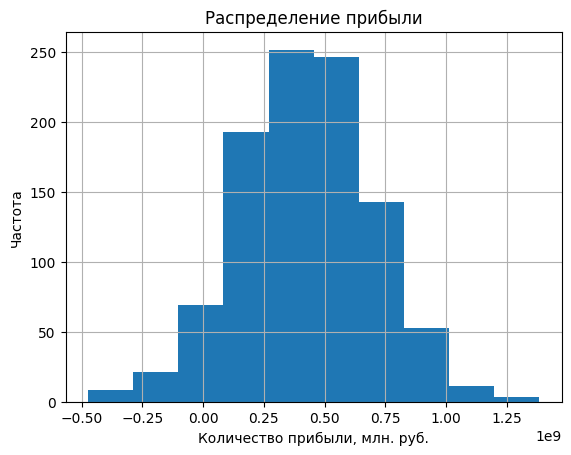

In [132]:
print("Первый регион data_0:")
bootstrap(target_0, predicted_0)

Второй регион data_1:
Средняя прибыль для региона: 459721115.92580837 млн. руб.
95% доверительный интервал от: 39639303.79013939
95% доверительный интервал до: 852350098.7033564
Риск убытка: 1.0999999999999999 %


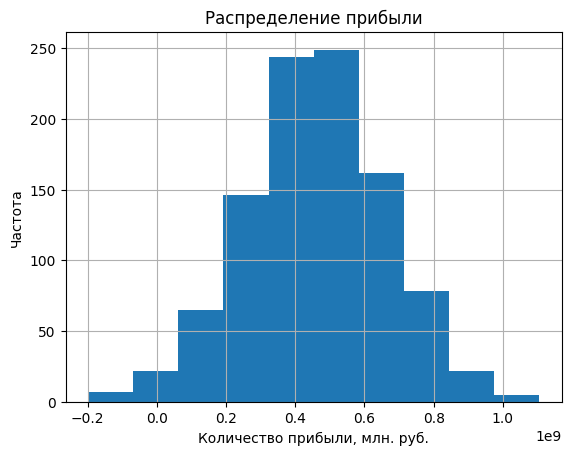

In [133]:
print("Второй регион data_1:")
bootstrap(target_1, predicted_1)

Третий регион data_2:
Средняя прибыль для региона: 340932280.2485709 млн. руб.
95% доверительный интервал от: -187995540.09643254
95% доверительный интервал до: 829267437.2581307
Риск убытка: 10.100000000000001 %


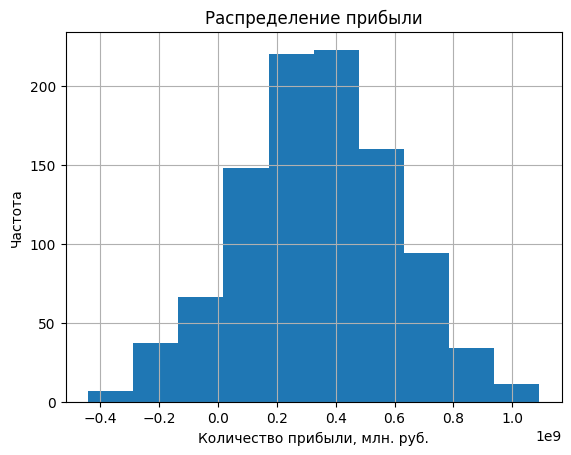

In [134]:
print("Третий регион data_2:")
bootstrap(target_2, predicted_2)

По результатам применения метода bootstrap для оценки прибыли и рисков по трем регионам, можно сделать следующие выводы:

- Первый регион (data_0):
  - Средняя прибыль составляет 419,58 млн руб., что свидетельствует о высоком потенциале для получения дохода.
  - 95%-й доверительный интервал прибыли колеблется от -127,41 млн руб. до 922,25 млн руб., что указывает на значительный разброс возможных результатов.
  - Риск убытка составляет 5,6%, что находится в допустимых пределах, но при этом требует осторожности при инвестициях.

- Второй регион (data_1):
  - Средняя прибыль — 459,72 млн руб., что является наибольшим среди всех регионов.
  - 95%-й доверительный интервал варьируется от 39,64 млн руб. до 852,35 млн руб., что говорит о более стабильных прогнозах по сравнению с первым регионом.
  - Риск убытка всего 1,1%, что делает этот регион наиболее безопасным и перспективным для разработки.

- Третий регион (data_2):
  - Средняя прибыль составляет 340,93 млн руб., что ниже, чем в других регионах.
  - 95%-й доверительный интервал — от -188 млн руб. до 829,27 млн руб., что указывает на значительные риски и неопределенности.
  - Риск убытка самый высокий среди всех регионов — 10,1%, что делает третий регион самым рискованным для инвестирования.

На основании анализа среднего дохода, доверительных интервалов и уровня риска, наиболее перспективным регионом для разработки является второй регион (data_1). Только второй регион (data_1) имеет риск убытков ниже 2.5% — его показатель составляет всего 1.1%. Средняя прибыль же этого региона также одна из самых высоких — 459.72 млн рублей. Также, 95%-й доверительный интервал полностью лежит в положительном диапозоне и свидетельствует о том, что даже при не самом благоприятном выборе скважин разработка окупится. Таким образом, он показывает наибольшую прибыль с минимальным риском убытков. Первый регион data_0 также имеет потенциал, но более высокий риск убытков (5.6%) и широкий доверительный интервал требуют осторожности. Третий регион data_2 имеет самый высокий риск убытков (10.1%) и менее стабильные прогнозы, что делает его наименее предпочтительным для инвестиций. Следовательно, для разработки лучше выбрать второй регион, который является наименее рискованным и самым прибыльным из допустимых вариантов.

## Общий вывод

Итак, в данной работе перед нами стояла задача построить модель для определения региона, где добыча нефти принесёт наибольшую прибыль.

Компания предоставила данные по характеристикам и запасам нефти в трёх регионах с целью оценки их перспективности. Для выбора наиболее подходящего региона была проведена работа по построению модели машинного обучения для прогнозирования объёмов добычи нефти и оценки экономической целесообразности разработки скважин.

В первой части проекта была выполнена важная работа по подготовке данных для построения модели прогнозирования запасов нефти. Мы загрузили три исходных датафрейма, содержащих идентификаторы скважин, количественные признаки и целевой признак, отражающий объем запасов нефти. В ходе исследования данные были тщательно подготовлены: удалены выбросы в признаках, что позволило нам удалить их, минимизировав возможное негативное влияние на обучение модели, проанализированы корреляции признаков и выявлено, что признак f2 демонстрирует значительную взаимосвязь с целевым признаком product, тогда как другие признаки (f0 и f1) имеют слабую корреляцию.

Далее модель линейной регрессии была обучена на данных каждого региона. Была проведена оценка производительности модели линейной регрессии на основе обучающей и валидационной выборок. Результаты предсказаний по трем регионам позволяют выделить ключевые аспекты их характеристик и рисков.

Регион data_0, хотя и демонстрирует высокий средний запас нефти, имеет значительную ошибку RMSE (37.6). Это указывает на то, что предсказания модели в этом регионе могут быть ненадежными, и существует риск значительных отклонений от реальных значений запасов. Регион data_1, напротив, показал наименьшую ошибку RMSE (0.888), что свидетельствует о высокой точности предсказаний. Хотя средний запас сырья в этом регионе ниже, чем в других, стабильность предсказаний делает его наиболее надежным вариантом для разработки. Третий регион data_2 обладает самым высоким средним запасом, однако также характеризуется высокой ошибкой RMSE (40.05), что ставит его на уровень риска, сопоставимый с первым регионом.

На этапе подготовки к расчету прибыли мы провели анализ, который показал, что для безубыточной разработки новых скважин необходим средний объем нефти в 111.11 тыс. баррелей на одну скважину. Однако, средние предсказанные запасы нефти в регионах оказались ниже этого уровня: 92.41 тыс. баррелей в первом, 68.81 тыс. баррелей во втором и 94.99 тыс. баррелей в третьем регионах. Это свидетельствует о том, что в целом предсказанные объемы нефти в каждом регионе не достигают необходимого уровня для окупаемости, отставая на минимум 16 тыс. баррелей.

Тем не менее, дальнейшие расчеты, касающиеся 200 скважин с наибольшими предсказанными запасами, показали, что их объемы в каждом из регионов превышают уровень безубыточности. В первом регионе наблюдается превышение на 41.42 тыс. баррелей, во втором — 27.63 тыс. баррелей, а в третьем — 35.75 тыс. баррелей. Это говорит о том, что, хотя средние запасы одной отдельной скважины недостаточны для обеспечения окупаемости, отбор наиболее прибыльных 200 скважин в каждом регионе может обеспечить финансовую стабильность и избежать убытков.

Это говорит нам о том, что при выборе скважин для разработки следует акцентировать внимание на отборе наиболее перспективных объектов. Лидирующий первый регион data_0, имея наибольшее превышение над безубыточным уровнем, демонстрирует наибольший потенциал для успешной разработки, в то время как другие регионы также могут предоставить возможности при правильной селекции скважин.

Рассчитав прибыль на основе выбранных скважин и предсказанных значений модели для каждого региона можно сказать, все три региона приносят прибыль, но первый регион (data_0) выделяется как самый прибыльный, а второй регион (data_1), несмотря на свою высокую предсказуемость, оказался наименее доходным.

И в конце работы мы посчитали риски и прибыль для каждого региона применив технику Bootstrap. По результатам применения метода Bootstrap для оценки прибыли и рисков, выявлены следующие ключевые моменты:

 - Первый регион (data_0): Средняя прибыль составила 419,58 млн руб. с риском убытка в 5,6%. 95%-й доверительный интервал варьируется от -127,41 до 922,25 млн руб., что указывает на существенный разброс возможных исходов. Несмотря на высокую потенциальную прибыль, риск убытков в этом регионе значительно выше.
 - Второй регион (data_1): Средняя прибыль составила 459,72 млн руб. с минимальным риском убытка — всего 1,1%. Доверительный интервал прибыли варьируется от 39,64 до 852,35 млн руб., что делает его наиболее стабильным и предсказуемым регионом для инвестиций. Это регион с наибольшей прибыльностью и минимальными рисками.
 - Третий регион (data_2): Средняя прибыль составила 340,93 млн руб., но риск убытка достигает 10,1%. Доверительный интервал от -188 млн до 829,27 млн руб. указывает на высокую неопределённость и значительные риски для инвестиций.
На основании анализа можно сделать вывод, что второй регион (data_1) является наиболее перспективным для разработки. Он демонстрирует максимальную прибыль среди всех трёх регионов при минимальных рисках убытка. В отличие от других регионов, вероятность убытков здесь составляет всего 1,1%, а 95%-й доверительный интервал не выходит за пределы положительных значений, что говорит о рентабельности даже при неблагоприятных условиях, и показывает, что даже при неблагоприятном выборе скважин проект останется прибыльным.

Первый регион также имеет потенциал для получения прибыли, однако более высокий риск (5,6%) и широкий разброс возможных исходов требуют осторожного подхода. Третий регион показал наибольшие риски, что делает его менее предпочтительным для инвестиций.

Таким образом, для разработки рекомендуется выбрать второй регион data_1, который сочетает в себе высокую прибыль и минимальные риски.